In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
from scipy import signal
from scipy.stats import skew
from scipy.stats import pearsonr
from scipy.signal import detrend
import matplotlib.ticker as mticker
from sklearn.utils import resample
import collections
import pickle
#from xrft import detrend

In [3]:
# ADDITIONAL FUNCTIONS

# CODE TO CALCULATE SEASONAL AVERAGE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')


# CODE TO SHIFT CCSM DATA BY 1 MONTH (given weird NCAR conventions that calendar date is end of time bound for each month)

def shift_dates_1M(dat):
    y_first = str(dat.time.values[0].year).zfill(4)
    y_last = str(dat.time.values[-2].year).zfill(4)

    time2 = xr.cftime_range(start=str(y_first)+'-01-01', end=str(y_last)+'-12-01', freq="1MS", calendar="noleap")
    dat = dat.assign_coords(time=time2)
    return dat

In [9]:
# PATHS TO DATA FILES

direc = '/tigress/janewb/public_html/HITOPO/'
diag = 't_surf'
files = {}

# files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diag+'.00010101-03000101.atmos_month.nc'
# files['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diag+'.00010101-02050101.atmos_month.nc'
# files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diag+'.00010101-06000101.atmos_month.nc'
# files['obs'] = '/tigress/janewb/OBS/HadISSTv1.1/HadISST_sst.nc'
# files['obs_ersst'] = '/tigress/janewb/OBS/ERSSTv5/ersst.v5.185401-202012.nc'
# files['ctrl_ccsm'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.pop.h.SSTregrid.100001-130012.nc'
# files['cam_ccsm'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.pop.h.SSTregrid.000101-029912.nc'
# files['ctrl_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/b40.1850.track1.1deg.006.pop.h.nino3_nino34.100001-130012.nc'
# files['cam_ccsm_nino'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/ccsm4pi_topo2.pop.h.nino3_nino34.000101-029912.nc'

files['ctrl'] = direc+'flor.ctrl.sst.nc'
files['cam'] = direc+'flor.cam.sst.nc'
files['hitopo'] = direc+'flor.hitopo.sst.nc'
files['obs'] = direc+'obs.hadisst.sst.nc'
files['obs_ersst'] = direc+'obs.ersstv5.sst.nc'
files['ctrl_ccsm'] = direc+'ccsm4.ctrl.sst.nc'
files['cam_ccsm'] = direc+'ccsm4.ideal_cam.sst.nc'


In [10]:
%%time

# DATA CLEANING
x = 'lon'
y = 'lat'
sst_var = 'sst'
units = 'C'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1947'#'1947'
obs_tmax = '2019'#'2019'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'obs':'gregorian', # checked using Pyferret function (list `SST,return=cal`)
             'ctrl_ccsm':'noleap',
             'cam_ccsm':'noleap',
             'obs_ersst':'gregorian' # this calendar for second half, 360-day for first maybe
            }

dat = {}
sst = {}
tsel = {}


# FLOR Runs

for key in ['ctrl','cam','hitopo']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'t_surf':'sst'})
    sst[key] = dat[key].sst-273.15
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    sst[key] = sst[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tsel[key] = sst[key].sel(time = slice(model_tmin,model_tmax))
    
for key in ['ctrl_ccsm']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = shift_dates_1M(dat[key])
    dat[key] = dat[key].rename({'sst_regrid':'sst'})
    sst[key] = dat[key].sst
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    tsel[key] = sst[key]#.sel(time = slice(model_tmin,model_tmax))
    
for key in ['cam_ccsm']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = shift_dates_1M(dat[key])
    dat[key] = dat[key].rename({'sst_regrid':'sst'})
    sst[key] = dat[key].sst
    sst[key].attrs = dat[key].attrs
    sst[key].attrs['units'] = units
    tsel[key] = sst[key]#.sel(time = slice(model_tmin,model_tmax))
    
# OBSERVATIONS

# HADISST
dat['obs'] = xr.open_dataset(files['obs'])
dat['obs'] = dat['obs'].rename({'longitude': 'lon','latitude': 'lat'})
dat['obs'] = dat['obs'].sortby('lat', ascending=True)
dat['obs'] = dat['obs'].assign_coords(lon=(dat['obs'].lon % 360)).roll(lon=180, roll_coords=True)
sst['obs'] = dat['obs'].sst
sst['obs'].attrs = dat['obs'].attrs
tsel['obs'] = sst['obs'].sel(time = slice(obs_tmin,obs_tmax))

# ERSST
dat['obs_ersst'] = xr.open_dataset(files['obs_ersst'])
sst['obs_ersst'] = dat['obs_ersst'].sst
sst['obs_ersst'].attrs = dat['obs_ersst'].attrs
tsel['obs_ersst'] = sst['obs_ersst'].sel(time = slice(obs_tmin,obs_tmax))


CPU times: user 40 s, sys: 27.4 s, total: 1min 7s
Wall time: 25.2 s


In [11]:
# REGIONS

# Region to get rid of NaNs for detrending
xmin = -175+360
xmax = -85+360
ymin = -10
ymax = 10

# Nino 3.4 Region
ymin34 = -5
ymax34 = 5
xmin34 = -170+360
xmax34 = -120+360

#Nino 3 Region
ymin3 = -5
ymax3 = 5
xmin3 = -150+360
xmax3 = -90+360

In [12]:
%%time
# DETREND THE DATA
# Need to step through grid because Scipy function can't handle NaNs at land points (could probably do more efficiently)
def detrend_masked(data):
    detrended = np.copy(data.values)
    for i in np.arange(len(data.lat)):
        for j in np.arange(len(data.lon)):
            x = data[:,i,j] 
            if np.all(~np.isnan(x)):
                detrended[:,i,j] = detrend(x,axis=0)
    return detrended

detrended = {}

for key in ['obs', 'obs_ersst','ctrl','cam','hitopo','cam_ccsm','ctrl_ccsm']:
    tselreg = tsel[key].sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax)) # select region so it runs faster
    detrended[key] = detrend_masked(tselreg)
    detrended[key] = xr.DataArray(detrended[key], coords=[tselreg.time, tselreg.lat, tselreg.lon], dims=["time", "lat", "lon"])


CPU times: user 35min 52s, sys: 1min 31s, total: 37min 23s
Wall time: 57.3 s


In [13]:
%%time
# DATA ANALYSIS

climatology = {}
anomaly = {}
stdv = {}
skewness = {}
nino34 = {}
nino3 = {}
nino34_5pt = {}
nino3_5pt = {}
nino34_stdv = {}
nino3_stdv = {}
nino34_skew = {}
nino3_skew = {}
nino34_sst = {}
nino3_sst = {}
nino34_stdv_mean = {}
nino3_stdv_mean = {}
nino34_stdv_norm = {}
nino3_stdv_norm = {}


for key in ['obs', 'obs_ersst','ctrl','cam','hitopo','cam_ccsm','ctrl_ccsm']:
    
    # calculate SST averages over Nino 3.4 and Nino 3 regions
    nino34_sst[key] = detrended[key].sel(lon = slice(xmin34,xmax34),lat = slice(ymin34,ymax34)).mean(dim=['lat','lon'])
    nino3_sst[key] = detrended[key].sel(lon = slice(xmin3,xmax3),lat = slice(ymin3,ymax3)).mean(dim=['lat','lon'])

    # calculate SST climatology
    climatology[key] = detrended[key].groupby('time.month').mean('time')
    
    # calculate anomalies from SST climatology
    anomaly[key] = detrended[key].groupby('time.month') - climatology[key]
    
    # calculate anomaly averages over Nino 3.4 and Nino 3 regions
    nino34[key] = anomaly[key].sel(lon = slice(xmin34,xmax34),lat = slice(ymin34,ymax34)).mean(dim=['lat','lon'])
    nino3[key] = anomaly[key].sel(lon = slice(xmin3,xmax3),lat = slice(ymin3,ymax3)).mean(dim=['lat','lon'])
    
    # calculate 5-pt running mean
    nino34_5pt[key] = nino34[key].rolling(time=5, center=True).mean().dropna('time')
    nino3_5pt[key] = nino3[key].rolling(time=5, center=True).mean().dropna('time')
    
    # calculate stdv of SST anomalies
    stdv[key] = anomaly[key].groupby('time.month').var(dim='time')**0.5
    
    # calculate stdv averages over Nino 3.4 and Nino 3 regions
    nino34_stdv[key] = stdv[key].sel(lon = slice(xmin34,xmax34),lat = slice(ymin34,ymax34)).mean(dim=['lat','lon'])
    nino3_stdv[key] = stdv[key].sel(lon = slice(xmin3,xmax3),lat = slice(ymin3,ymax3)).mean(dim=['lat','lon'])
    
    # Mean of monthly stdv
    nino34_stdv_mean[key] = nino34_stdv[key].mean(dim='month')
    nino3_stdv_mean[key] = nino3_stdv[key].mean(dim='month')
    
    # Monthly stdv normalized by mean stdv
    nino34_stdv_norm[key] = nino34_stdv[key]/nino34_stdv_mean[key]
    nino3_stdv_norm[key] = nino3_stdv[key]/nino3_stdv_mean[key]
    
    # calculate skewness of SST anomalies
    skewness[key] = skew(anomaly[key], axis = 0)
    skewness[key] = xr.DataArray(skewness[key], coords=[stdv[key].lat, stdv[key].lon], dims=["lat", "lon"])
    
    # calculate skewness averages
    nino34_skew[key] = skewness[key].sel(lon = slice(xmin34,xmax34), lat = slice(ymin34,ymax34)).mean(dim = ['lon','lat'])
    nino3_skew[key] = skewness[key].sel(lon = slice(xmin3,xmax3),lat = slice(ymin3,ymax3)).mean(dim=['lon','lat'])
    

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 1min 24s, sys: 5.87 s, total: 1min 30s
Wall time: 2.59 s


# Calculate confidence intervals on monthly stdv.
# ** Skip and load below if already ran **

In [9]:
%%time
# Create bootstrap samples
def bootstrap_samples(dat, n_samples):
    shape = np.shape(dat)
    x = dat.values
    xstar = np.empty([shape[0],shape[1],shape[2],n_samples])
    for n in np.arange(n_samples):
        xstar[:,:,:,n] = resample(x,replace=True)
    return xstar

# Initialize dictionaries for results
# Could make more concise with dict options for nino 3 vs 34, and low v high
nino34_stdv_ci = collections.defaultdict(dict)
nino3_stdv_ci = collections.defaultdict(dict)
# Mean stdv
nino34_stdv_mean_ci = collections.defaultdict(dict)
nino3_stdv_mean_ci = collections.defaultdict(dict)
# Monthly stdv normalized by mean stdv
nino34_stdv_norm_ci = collections.defaultdict(dict)
nino3_stdv_norm_ci = collections.defaultdict(dict)

# Settings for bootstrapping confidence intervals
n_samples = 1000 # number of times resample to create sample of same size as dataset
ci = 0.05 # 0.05 (5%) on top and bottom to create 90% confidence intervals

for key in ['obs','obs_ersst','ctrl','cam','hitopo','cam_ccsm','ctrl_ccsm']:
    print(key)

    # Select anomaly data
    x_dat = anomaly[key]

    # Find time indices of different each of 12 months
    month_indices = x_dat.groupby("time.month").groups

    # Initialize month x sample fields to populate in next loop
    nino34_stdvstar = np.empty([12, n_samples])
    nino3_stdvstar = np.empty([12, n_samples])
    
    # Split data up to resample by month
    for month in np.arange(1,13):
        
        # Select data for given month
        month_dat = x_dat[month_indices[month]]
        
        # Resample data with replacement
        xstar = bootstrap_samples(month_dat, n_samples)

        # Put data back in xarray format and take stdv
        xstar_dat = xr.DataArray(xstar, coords=[month_dat.time, month_dat.lat, month_dat.lon, np.arange(n_samples)], dims=["time","lat","lon","sample"])
        stdvstar = xstar_dat.var(dim='time')**0.5

        # Calculate monthly variance for resampled data
        nino34_stdvstar[month-1,:] = stdvstar.sel(lon = slice(xmin34,xmax34),lat = slice(ymin34,ymax34)).mean(dim=['lat','lon']).values
        nino3_stdvstar[month-1,:] = stdvstar.sel(lon = slice(xmin3,xmax3),lat = slice(ymin3,ymax3)).mean(dim=['lat','lon']).values
    
    # Put data in xarray format
    nino34_stdvstar = xr.DataArray(nino34_stdvstar, coords=[nino34_stdv[key].month, np.arange(n_samples)], dims=["month","sample"])
    nino3_stdvstar = xr.DataArray(nino3_stdvstar, coords=[nino3_stdv[key].month, np.arange(n_samples)], dims=["month","sample"])

    # Calculate CI for monthly stdv
    diff34 = nino34_stdvstar - nino34_stdv[key]
    diff3 = nino3_stdvstar - nino3_stdv[key]
    nino34_stdv_ci[key]['low'] = nino34_stdv[key] + diff34.quantile(ci,dim='sample')
    nino3_stdv_ci[key]['low'] = nino3_stdv[key] + diff3.quantile(ci,dim='sample')
    nino34_stdv_ci[key]['high'] = nino34_stdv[key] + diff34.quantile(1-ci,dim='sample')
    nino3_stdv_ci[key]['high'] = nino3_stdv[key] + diff3.quantile(1-ci,dim='sample')

    # Calculate CI for mean stdv
    nino34_stdv_meanstar = nino34_stdvstar.mean(dim='month')
    nino3_stdv_meanstar = nino3_stdvstar.mean(dim='month')
    diff34 = nino34_stdv_meanstar - nino34_stdv_mean[key]
    diff3 = nino3_stdv_meanstar - nino3_stdv_mean[key]
    nino34_stdv_mean_ci[key]['low'] = nino34_stdv_mean[key] + diff34.quantile(ci,dim='sample')
    nino3_stdv_mean_ci[key]['low'] = nino3_stdv_mean[key] + diff3.quantile(ci,dim='sample')
    nino34_stdv_mean_ci[key]['high'] = nino34_stdv_mean[key] + diff34.quantile(1-ci,dim='sample')
    nino3_stdv_mean_ci[key]['high'] = nino3_stdv_mean[key] + diff3.quantile(1-ci,dim='sample')
    
    # Calculate CI for monthly stdv norm by mean stdv
    nino34_stdv_normstar = nino34_stdvstar/nino34_stdv_meanstar
    nino3_stdv_normstar = nino3_stdvstar/nino3_stdv_meanstar
    diff34 = nino34_stdv_normstar - nino34_stdv_norm[key]
    diff3 = nino3_stdv_normstar - nino3_stdv_norm[key]
    nino34_stdv_norm_ci[key]['low'] = nino34_stdv_norm[key] + diff34.quantile(ci,dim='sample')
    nino3_stdv_norm_ci[key]['low'] = nino3_stdv_norm[key] + diff3.quantile(ci,dim='sample')
    nino34_stdv_norm_ci[key]['high'] = nino34_stdv_norm[key] + diff34.quantile(1-ci,dim='sample')
    nino3_stdv_norm_ci[key]['high'] = nino3_stdv_norm[key] + diff3.quantile(1-ci,dim='sample')


obs
obs_ersst
ctrl
cam
hitopo
cam_ccsm
ctrl_ccsm
CPU times: user 30min 38s, sys: 5min 19s, total: 35min 57s
Wall time: 25min 48s


In [10]:
# Save out confidence intervals

with open('nino34_stdv_ci.pickle', 'wb') as handle:
    pickle.dump(nino34_stdv_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('nino3_stdv_ci.pickle', 'wb') as handle:
    pickle.dump(nino3_stdv_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('nino34_stdv_mean_ci.pickle', 'wb') as handle:
    pickle.dump(nino34_stdv_mean_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('nino3_stdv_mean_ci.pickle', 'wb') as handle:
    pickle.dump(nino3_stdv_mean_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('nino34_stdv_norm_ci.pickle', 'wb') as handle:
    pickle.dump(nino34_stdv_norm_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('nino3_stdv_norm_ci.pickle', 'wb') as handle:
    pickle.dump(nino3_stdv_norm_ci, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load confidence intervals.

In [14]:
with open('nino34_stdv_ci.pickle', 'rb') as handle:
    nino34_stdv_ci= pickle.load(handle)
with open('nino3_stdv_ci.pickle', 'rb') as handle:
    nino3_stdv_ci= pickle.load(handle)

with open('nino34_stdv_mean_ci.pickle', 'rb') as handle:
    nino34_stdv_mean_ci= pickle.load(handle)
with open('nino3_stdv_mean_ci.pickle', 'rb') as handle:
    nino3_stdv_mean_ci= pickle.load(handle)
    
with open('nino34_stdv_norm_ci.pickle', 'rb') as handle:
    nino34_stdv_norm_ci= pickle.load(handle)
with open('nino3_stdv_norm_ci.pickle', 'rb') as handle:
    nino3_stdv_norm_ci= pickle.load(handle)


# Make plots.

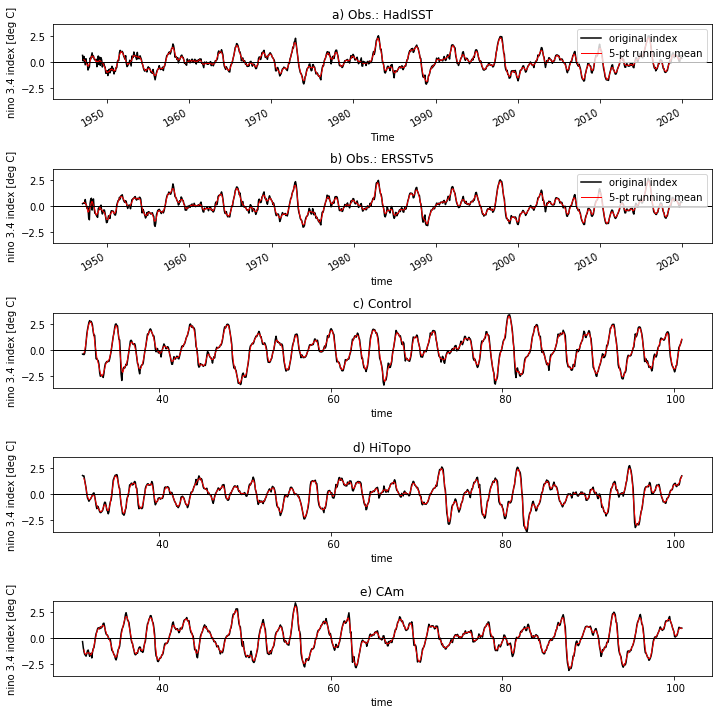

In [15]:
# ENSO Time Series

fig = plt.figure(figsize=(10,10))

ylim1 = -3.6
ylim2 = 3.6

ax1 = plt.subplot(5,1,1)
nino34['obs'].plot(color='k',label='original index')
nino34_5pt['obs'].plot(linewidth=1,color='r',label='5-pt running mean')
ax1.set_title('a) Obs.: HadISST')
ax1.set_ylabel('nino 3.4 index [deg C]')
ax1.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)
plt.legend()

ax2 = plt.subplot(5,1,2)
nino34['obs_ersst'].plot(color='k',label='original index')
nino34_5pt['obs_ersst'].plot(linewidth=1,color='r',label='5-pt running mean')
ax2.set_title('b) Obs.: ERSSTv5')
ax2.set_ylabel('nino 3.4 index [deg C]')
ax2.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)
plt.legend()

ax3 = plt.subplot(5,1,3)
nino34['ctrl'].sel(time= slice('0031','0100')).plot(color='k')
nino34_5pt['ctrl'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax3.set_title('c) Control')
ax3.set_ylabel('nino 3.4 index [deg C]')
ax3.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

ax4 = plt.subplot(5,1,4)
nino34['hitopo'].sel(time = slice('0031','0100')).plot(color='k')
nino34_5pt['hitopo'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax4.set_title('d) HiTopo')
ax4.set_ylabel('nino 3.4 index [deg C]')
ax4.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

ax5 = plt.subplot(5,1,5)
nino34['cam'].sel(time = slice('0031','0100')).plot(color='k')
nino34_5pt['cam'].sel(time = slice('0031','0100')).plot(linewidth=1,color='r')
ax5.set_title('e) CAm')
ax5.set_ylabel('nino 3.4 index [deg C]')
ax5.set_ylim([ylim1,ylim2])
plt.axhline(color='k',linewidth=1)

plt.tight_layout()

#plt.savefig('nino34_timeseries.png', dpi = 600)

In [16]:
# Power spectra calculation
def powerspectra(nino):
    x = nino.rolling(time=3, center=True).mean().dropna('time')
    freq, spectra = signal.welch(x, fs=12, detrend='linear',scaling='density',window='boxcar') #boxcar is same as daniell
    power = spectra*freq*np.log(2)
    powernorm = power/np.max(power)
    return freq, power, powernorm

freq34 = {}
power34 = {}
powernorm34 = {}
freq3 = {}
power3 = {}
powernorm3 = {}
freq34_sst = {}
power34_sst = {}
powernorm34_sst = {}
freq3_sst = {}
power3_sst = {}
powernorm3_sst = {}
for key in ['obs', 'obs_ersst', 'hitopo', 'ctrl', 'cam', 'ctrl_ccsm', 'cam_ccsm']:
    freq34[key], power34[key], powernorm34[key] = powerspectra(nino34[key])
    freq3[key], power3[key], powernorm3[key] = powerspectra(nino3[key])
    freq34_sst[key], power34_sst[key], powernorm34_sst[key] = powerspectra(nino34_sst[key])
    freq3_sst[key], power3_sst[key], powernorm3_sst[key] = powerspectra(nino3_sst[key])

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/

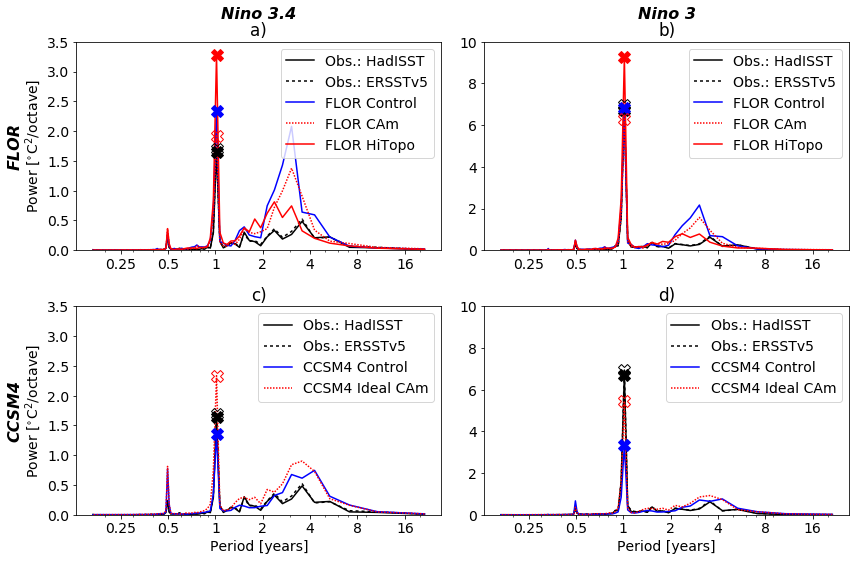

In [17]:
# Power Spectra Plus Seasonal Cycle

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
fs_label = 16

ylim1 = 0
ylim2_34 = 3.5
ylim2_3 = 10
xlim1 = 0
xlim2 = 16
fs = 12

i = np.argmax(power34_sst['hitopo'])
ms = 12 #markersize

ax1 = plt.subplot(2,2,1)
plt.plot(1/freq34_sst['obs'], power34_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34_sst['obs_ersst'], power34_sst['obs_ersst'],color='k', dashes = [2,2,2,2], label='Obs.: ERSSTv5')
plt.plot(1/freq34_sst['ctrl'], power34_sst['ctrl'],color='b',label='FLOR Control')
plt.plot(1/freq34_sst['cam'], power34_sst['cam'],color='r',dashes=[1,1,1,1],label='FLOR CAm')
plt.plot(1/freq34_sst['hitopo'], power34_sst['hitopo'],color='r',label='FLOR HiTopo')
# Markers of 1 year amplitude
plt.plot(1/freq34_sst['obs'][i],power34_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq34_sst['obs_ersst'][i],power34_sst['obs_ersst'][i],marker='X',color='k',markersize=ms, fillstyle='none')
plt.plot(1/freq34_sst['ctrl'][i],power34_sst['ctrl'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq34_sst['cam'][i],power34_sst['cam'][i],marker='X',color='r',markersize=ms,fillstyle='none')
plt.plot(1/freq34_sst['hitopo'][i],power34_sst['hitopo'][i],marker='X',color='r',markersize=ms)
ax1.set_title('a)')
ax1.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax1.set_xlabel('Period [years]')
ax1.set_ylim([ylim1, ylim2_34])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax2 = plt.subplot(2,2,2)
plt.plot(1/freq3_sst['obs'], power3_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3_sst['obs_ersst'], power3_sst['obs_ersst'],color='k', dashes = [2,2,2,2], label='Obs.: ERSSTv5')
plt.plot(1/freq3_sst['ctrl'], power3_sst['ctrl'],color='b',label='FLOR Control')
plt.plot(1/freq3_sst['cam'], power3_sst['cam'],color='r',dashes=[1,1,1,1],label='FLOR CAm')
plt.plot(1/freq3_sst['hitopo'], power3_sst['hitopo'],color='r',label='FLOR HiTopo')
# Markers of 1 year amplitude
plt.plot(1/freq3_sst['obs'][i],power3_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq3_sst['obs_ersst'][i],power3_sst['obs_ersst'][i],marker='X',color='k',markersize=ms, fillstyle='none')
plt.plot(1/freq3_sst['ctrl'][i],power3_sst['ctrl'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq3_sst['cam'][i],power3_sst['cam'][i],marker='X',color='r',markersize=ms,fillstyle='none')
plt.plot(1/freq3_sst['hitopo'][i],power3_sst['hitopo'][i],marker='X',color='r',markersize=ms)
ax2.set_title('b)')
#ax2.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
#ax2.set_xlabel('Period [years]')
ax2.set_ylim([ylim1, ylim2_3])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax3 = plt.subplot(2,2,3)
plt.plot(1/freq34_sst['obs'], power34_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq34_sst['obs_ersst'], power34_sst['obs_ersst'],color='k', dashes = [2,2,2,2], label='Obs.: ERSSTv5')
plt.plot(1/freq34_sst['ctrl_ccsm'], power34_sst['ctrl_ccsm'],color='b',label='CCSM4 Control')
plt.plot(1/freq34_sst['cam_ccsm'], power34_sst['cam_ccsm'],color='r',dashes=[1,1,1,1],label='CCSM4 Ideal CAm')
# Markers of 1 year amplitude
plt.plot(1/freq34_sst['obs'][i],power34_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq34_sst['obs_ersst'][i],power34_sst['obs_ersst'][i],marker='X',color='k',markersize=ms, fillstyle='none')
plt.plot(1/freq34_sst['ctrl_ccsm'][i],power34_sst['ctrl_ccsm'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq34_sst['cam_ccsm'][i],power34_sst['cam_ccsm'][i],marker='X',color='r',markersize=ms,fillstyle='none')
ax3.set_title('c)')
ax3.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax3.set_xlabel('Period [years]')
ax3.set_ylim([ylim1, ylim2_34])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

ax4 = plt.subplot(2,2,4)
plt.plot(1/freq3_sst['obs'], power3_sst['obs'],color='k',label='Obs.: HadISST')
plt.plot(1/freq3_sst['obs_ersst'], power3_sst['obs_ersst'],color='k', dashes = [2,2,2,2], label='Obs.: ERSSTv5')
plt.plot(1/freq3_sst['ctrl_ccsm'], power3_sst['ctrl_ccsm'],color='b',label='CCSM4 Control')
plt.plot(1/freq3_sst['cam_ccsm'], power3_sst['cam_ccsm'],color='r',dashes=[1,1,1,1],label='CCSM4 Ideal CAm')
# Markers of 1 year amplitude
plt.plot(1/freq3_sst['obs'][i],power3_sst['obs'][i],marker='X',color='k',markersize=ms)
plt.plot(1/freq3_sst['obs_ersst'][i],power3_sst['obs_ersst'][i],marker='X',color='k',markersize=ms, fillstyle='none')
plt.plot(1/freq3_sst['ctrl_ccsm'][i],power3_sst['ctrl_ccsm'][i],marker='X',color='b',markersize=ms)
plt.plot(1/freq3_sst['cam_ccsm'][i],power3_sst['cam_ccsm'][i],marker='X',color='r',markersize=ms,fillstyle='none')
ax4.set_title('d)')
#ax4.set_ylabel(r'Power [$^{\circ}$C$^2$/octave]')
ax4.set_xlabel('Period [years]')
ax4.set_ylim([ylim1, ylim2_3])
plt.xscale('log')
plt.legend()
plt.xticks(np.array([0.25,0.5,1,2,4,8,16]),('0.25','0.5','1','2','4','8','16'))

#labels
ax1.text(0.5,1.11,'Nino 3.4',fontsize = fs_label, style = 'italic', transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.11,'Nino 3',fontsize = fs_label,  style = 'italic', transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.19,0.5,'FLOR',fontsize = fs_label, style = 'italic', transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.19,0.5,'CCSM4',fontsize = fs_label, style = 'italic', transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')

plt.tight_layout()

#plt.savefig('enso_powerspectra_seasonal.pdf')
#plt.savefig('enso_powerspectra_seasonal.png', xpixels = 600)

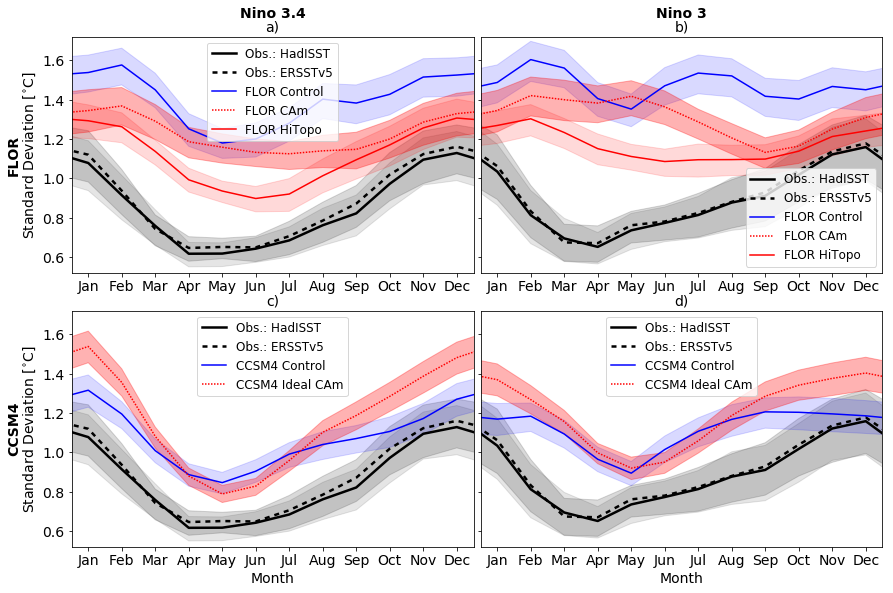

In [18]:
# Seasonal Cycle of Nino STDV

fig = plt.figure(figsize=(12,8))

ymin = 0.52 # 0 
ymax = 1.72 # 2.5

xmin = 13
xmax = 24

tax = np.arange(1,37,1)

legend_fs = 12

#Alpha values for uncertainty bars
a_obs = 0.1
a_obs_ersst = 0.15
a_ctrl = 0.15
a_hitopo = 0.15
a_cam = 0.3

nino34_Vx3 = {}
nino34_low_Vx3 = {}
nino34_high_Vx3 = {}
nino3_Vx3 = {}
nino3_low_Vx3 = {}
nino3_high_Vx3 = {}
for key in nino34_stdv.keys():
    nino34_Vx3[key] = np.tile(nino34_stdv[key].values,3)
    nino3_Vx3[key] = np.tile(nino3_stdv[key].values,3)
    nino34_low_Vx3[key] = np.tile(nino34_stdv_ci[key]['low'].values,3)
    nino3_low_Vx3[key] = np.tile(nino3_stdv_ci[key]['low'].values,3)
    nino34_high_Vx3[key] = np.tile(nino34_stdv_ci[key]['high'].values,3)
    nino3_high_Vx3[key] = np.tile(nino3_stdv_ci[key]['high'].values,3)
    

ax1 = plt.subplot(2,2,1)
plt.plot(tax,nino34_Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs'],nino34_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino34_Vx3['obs_ersst'], color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs_ersst'],nino34_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino34_Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.fill_between(tax,nino34_low_Vx3['ctrl'],nino34_high_Vx3['ctrl'],color='b',alpha=a_ctrl)
plt.plot(tax,nino34_Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.fill_between(tax,nino34_low_Vx3['cam'],nino34_high_Vx3['cam'],color='r',alpha=a_cam)
plt.plot(tax,nino34_Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
plt.fill_between(tax,nino34_low_Vx3['hitopo'],nino34_high_Vx3['hitopo'],color='r',alpha=a_hitopo)
#plt.ylabel('nino 3.4 index variance')
plt.legend(fontsize=legend_fs)
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.ylabel(r'Standard Deviation [$^{\circ}$C]')
plt.title('a)',fontsize=14)

ax2 = plt.subplot(2,2,2)
plt.plot(tax,nino3_Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs'],nino3_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino3_Vx3['obs_ersst'], color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs_ersst'],nino3_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino3_Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.fill_between(tax,nino3_low_Vx3['ctrl'],nino3_high_Vx3['ctrl'],color='b',alpha=a_ctrl)
plt.plot(tax,nino3_Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.fill_between(tax,nino3_low_Vx3['cam'],nino3_high_Vx3['cam'],color='r',alpha=a_cam)
plt.plot(tax,nino3_Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
plt.fill_between(tax,nino3_low_Vx3['hitopo'],nino3_high_Vx3['hitopo'],color='r',alpha=a_hitopo)
#plt.ylabel('nino 3 index variance')
plt.legend(fontsize=legend_fs)
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
ax2.set_yticklabels([])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.title('b)',fontsize=14)

ax3 = plt.subplot(2,2,3)
plt.plot(tax,nino34_Vx3['obs'],color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs'],nino34_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino34_Vx3['obs_ersst'],color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs_ersst'],nino34_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino34_Vx3['ctrl_ccsm'],color = 'b', label = 'CCSM4 Control')
plt.fill_between(tax,nino34_low_Vx3['ctrl_ccsm'],nino34_high_Vx3['ctrl_ccsm'],color='b',alpha=a_ctrl)
plt.plot(tax,nino34_Vx3['cam_ccsm'],color = 'r', dashes=[1,1,1,1], label = 'CCSM4 Ideal CAm')
plt.fill_between(tax,nino34_low_Vx3['cam_ccsm'],nino34_high_Vx3['cam_ccsm'],color='r',alpha=a_cam)
#plt.ylabel('nino 3.4 index variance')
plt.legend(fontsize=12)
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.ylabel(r'Standard Deviation [$^{\circ}$C]')
plt.title('c)',fontsize=14)

ax4 = plt.subplot(2,2,4)
plt.plot(tax,nino3_Vx3['obs'],color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs'],nino3_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino3_Vx3['obs_ersst'],color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs_ersst'],nino3_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino3_Vx3['ctrl_ccsm'],color = 'b', label = 'CCSM4 Control')
plt.fill_between(tax,nino3_low_Vx3['ctrl_ccsm'],nino3_high_Vx3['ctrl_ccsm'],color='b',alpha=a_ctrl)
plt.plot(tax,nino3_Vx3['cam_ccsm'],color = 'r', dashes=[1,1,1,1], label = 'CCSM4 Ideal CAm')
plt.fill_between(tax,nino3_low_Vx3['cam_ccsm'],nino3_high_Vx3['cam_ccsm'],color='r',alpha=a_cam)
#plt.ylabel('nino 3 index variance')
plt.legend(fontsize=legend_fs)
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
ax4.set_yticklabels([])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.title('d)',fontsize=14)

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.16,0.5,'FLOR',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.16,0.5,'CCSM4',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')


plt.tight_layout(pad = 0)

#plt.savefig('twomodels_nino_var.png', bbox_inches='tight', dpi = 600)
#plt.savefig('twomodels_nino_var.pdf')

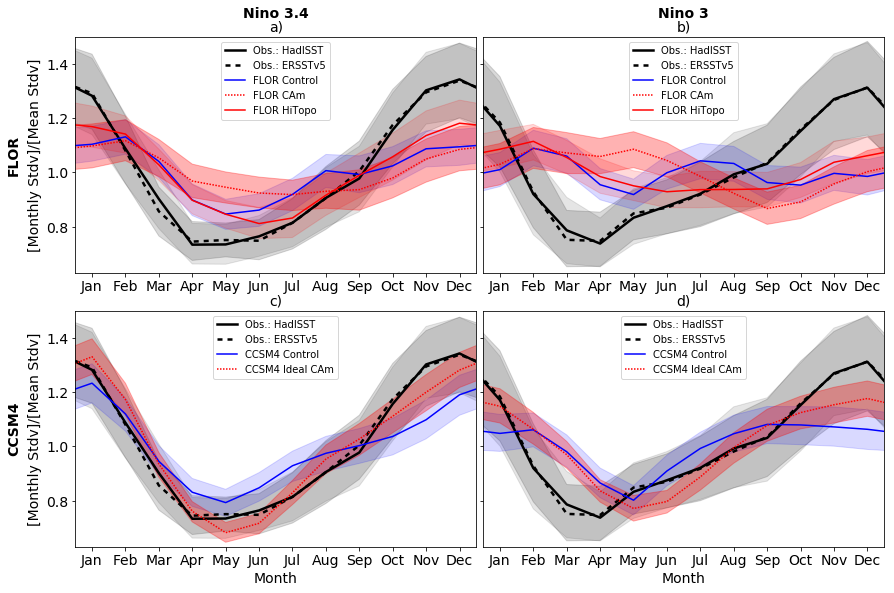

In [19]:
# Seasonal Cycle of Nino STDV Normalized

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})

ymin = 0.63
ymax = 1.5

xmin = 13
xmax = 24

tax = np.arange(1,37,1)

legend_fs = 10

#Alpha values for uncertainty bars
a_obs = 0.1
a_obs_ersst = 0.15
a_ctrl = 0.15
a_hitopo = 0.15
a_cam = 0.3

nino34_Vx3 = {}
nino34_low_Vx3 = {}
nino34_high_Vx3 = {}
nino3_Vx3 = {}
nino3_low_Vx3 = {}
nino3_high_Vx3 = {}
for key in nino34_stdv.keys():
    nino34_Vx3[key] = np.tile(nino34_stdv_norm[key].values,3)
    nino3_Vx3[key] = np.tile(nino3_stdv_norm[key].values,3)
    nino34_low_Vx3[key] = np.tile(nino34_stdv_norm_ci[key]['low'].values,3)
    nino3_low_Vx3[key] = np.tile(nino3_stdv_norm_ci[key]['low'].values,3)
    nino34_high_Vx3[key] = np.tile(nino34_stdv_norm_ci[key]['high'].values,3)
    nino3_high_Vx3[key] = np.tile(nino3_stdv_norm_ci[key]['high'].values,3)
    

ax1 = plt.subplot(2,2,1)
plt.plot(tax,nino34_Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs'],nino34_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino34_Vx3['obs_ersst'], color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs_ersst'],nino34_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino34_Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.fill_between(tax,nino34_low_Vx3['ctrl'],nino34_high_Vx3['ctrl'],color='b',alpha=a_ctrl)
plt.plot(tax,nino34_Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.fill_between(tax,nino34_low_Vx3['cam'],nino34_high_Vx3['cam'],color='r',alpha=a_cam)
plt.plot(tax,nino34_Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
plt.fill_between(tax,nino34_low_Vx3['hitopo'],nino34_high_Vx3['hitopo'],color='r',alpha=a_hitopo)
#plt.ylabel('nino 3.4 index variance')
plt.legend(fontsize=legend_fs,loc='upper center')
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.ylabel('[Monthly Stdv]/[Mean Stdv]')
plt.title('a)',fontsize=14)

ax2 = plt.subplot(2,2,2)
plt.plot(tax,nino3_Vx3['obs'], color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs'],nino3_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino3_Vx3['obs_ersst'], color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs_ersst'],nino3_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino3_Vx3['ctrl'], color = 'b', label = 'FLOR Control')
plt.fill_between(tax,nino3_low_Vx3['ctrl'],nino3_high_Vx3['ctrl'],color='b',alpha=a_ctrl)
plt.plot(tax,nino3_Vx3['cam'], color = 'r', dashes=[1,1,1,1], label = 'FLOR CAm')
plt.fill_between(tax,nino3_low_Vx3['cam'],nino3_high_Vx3['cam'],color='r',alpha=a_cam)
plt.plot(tax,nino3_Vx3['hitopo'], color = 'r', label = 'FLOR HiTopo')
plt.fill_between(tax,nino3_low_Vx3['hitopo'],nino3_high_Vx3['hitopo'],color='r',alpha=a_hitopo)
#plt.ylabel('nino 3 index variance')
plt.legend(fontsize=legend_fs,loc='upper center')
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
ax2.set_yticklabels([])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
#plt.xlabel('Month')
plt.title('b)',fontsize=14)

ax3 = plt.subplot(2,2,3)
plt.plot(tax,nino34_Vx3['obs'],color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs'],nino34_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino34_Vx3['obs_ersst'],color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino34_low_Vx3['obs_ersst'],nino34_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino34_Vx3['ctrl_ccsm'],color = 'b', label = 'CCSM4 Control')
plt.fill_between(tax,nino34_low_Vx3['ctrl_ccsm'],nino34_high_Vx3['ctrl_ccsm'],color='b',alpha=a_ctrl)
plt.plot(tax,nino34_Vx3['cam_ccsm'],color = 'r', dashes=[1,1,1,1], label = 'CCSM4 Ideal CAm')
plt.fill_between(tax,nino34_low_Vx3['cam_ccsm'],nino34_high_Vx3['cam_ccsm'],color='r',alpha=a_cam)
#plt.ylabel('nino 3.4 index variance')
plt.legend(fontsize=legend_fs,loc='upper center')
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.ylabel('[Monthly Stdv]/[Mean Stdv]')
plt.title('c)',fontsize=14)

ax4 = plt.subplot(2,2,4)
plt.plot(tax,nino3_Vx3['obs'],color = 'k', label = 'Obs.: HadISST', linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs'],nino3_high_Vx3['obs'],color='k',alpha=a_obs)
plt.plot(tax,nino3_Vx3['obs_ersst'],color = 'k', label = 'Obs.: ERSSTv5', dashes = [2,2,2,2], linewidth = 2.5)
plt.fill_between(tax,nino3_low_Vx3['obs_ersst'],nino3_high_Vx3['obs_ersst'],color='k',alpha=a_obs_ersst)
plt.plot(tax,nino3_Vx3['ctrl_ccsm'],color = 'b', label = 'CCSM4 Control')
plt.fill_between(tax,nino3_low_Vx3['ctrl_ccsm'],nino3_high_Vx3['ctrl_ccsm'],color='b',alpha=a_ctrl)
plt.plot(tax,nino3_Vx3['cam_ccsm'],color = 'r', dashes=[1,1,1,1], label = 'CCSM4 Ideal CAm')
plt.fill_between(tax,nino3_low_Vx3['cam_ccsm'],nino3_high_Vx3['cam_ccsm'],color='r',alpha=a_cam)
#plt.ylabel('nino 3 index variance')
plt.legend(fontsize=legend_fs,loc='upper center')
plt.ylim([ymin,ymax])
plt.xlim([xmin-0.5,xmax+0.5])
ax4.set_yticklabels([])
plt.xticks(np.arange(xmin, xmax+1, step=1),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Month')
plt.title('d)',fontsize=14)

#labels
ax1.text(0.5,1.08,'Nino 3.4',fontsize = 14, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.08,'Nino 3',fontsize = 14, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.17,0.5,'FLOR',fontsize = 14, transform=ax1.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')
ax3.text(-0.17,0.5,'CCSM4',fontsize = 14, transform=ax3.transAxes, rotation = 90, verticalalignment='center', fontweight='bold')


plt.tight_layout(pad = 0)

#plt.savefig('twomodels_nino_var_norm.png', bbox_inches='tight', dpi = 600)
#plt.savefig('twomodels_nino_var_norm.pdf')

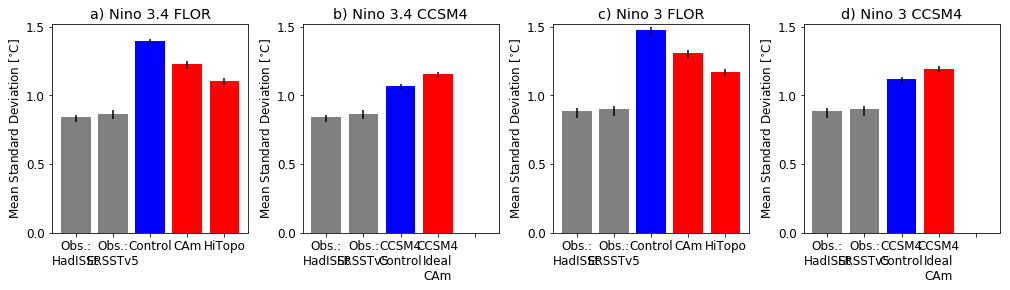

In [20]:
# Mean standard deviation

fig = plt.figure(figsize=(14,4))
plt.rcParams.update({'font.size': 12})

ymin = 0
ymax = 1.52

# Nino 3.4 FLOR
ax1 = plt.subplot(141)
y = np.array([nino34_stdv_mean['obs'],nino34_stdv_mean['obs_ersst'],nino34_stdv_mean['ctrl'],nino34_stdv_mean['cam'],nino34_stdv_mean['hitopo']])
yerr_low = np.array([nino34_stdv_mean_ci['obs']['low'],nino34_stdv_mean_ci['obs_ersst']['low'],nino34_stdv_mean_ci['ctrl']['low'],nino34_stdv_mean_ci['cam']['low'],nino34_stdv_mean_ci['hitopo']['low']])
yerr_high = np.array([nino34_stdv_mean_ci['obs']['high'],nino34_stdv_mean_ci['obs_ersst']['high'],nino34_stdv_mean_ci['ctrl']['high'],nino34_stdv_mean_ci['cam']['high'],nino34_stdv_mean_ci['hitopo']['high']])
yerr = np.stack([y-yerr_low,yerr_high-y])
plt.bar(np.arange(1,6,1), y, yerr = yerr, color=['grey', 'grey', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,6,1), ('Obs.:\nHadISSt', 'Obs.:\nERSSTv5', 'Control', 'CAm','HiTopo'))
ax1.set_title('a) Nino 3.4 FLOR')
plt.yticks([0,0.5,1,1.5])
ax1.set_ylabel('Mean Standard Deviation [$^{\circ}$C]')

# Nino 3.4 CCSM4
ax2 = plt.subplot(142)
y = np.array([nino34_stdv_mean['obs'],nino34_stdv_mean['obs_ersst'],nino34_stdv_mean['ctrl_ccsm'],nino34_stdv_mean['cam_ccsm'],0])
yerr_low = np.array([nino34_stdv_mean_ci['obs']['low'],nino34_stdv_mean_ci['obs_ersst']['low'],nino34_stdv_mean_ci['ctrl_ccsm']['low'],nino34_stdv_mean_ci['cam_ccsm']['low'],0])
yerr_high = np.array([nino34_stdv_mean_ci['obs']['high'],nino34_stdv_mean_ci['obs_ersst']['high'],nino34_stdv_mean_ci['ctrl_ccsm']['high'],nino34_stdv_mean_ci['cam_ccsm']['high'],0])
yerr = np.stack([y-yerr_low,yerr_high-y])
plt.bar(np.arange(1,6,1), y, yerr = yerr, color=['grey', 'grey', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,6,1), ('Obs.:\nHadISSt', 'Obs.:\nERSSTv5', 'CCSM4\nControl', 'CCSM4\nIdeal\nCAm',''))
ax2.set_title('b) Nino 3.4 CCSM4')
plt.yticks([0,0.5,1,1.5])
ax2.set_ylabel('Mean Standard Deviation [$^{\circ}$C]')

# Nino 3 FLOR
ax3 = plt.subplot(143)
y = np.array([nino3_stdv_mean['obs'],nino3_stdv_mean['obs_ersst'],nino3_stdv_mean['ctrl'],nino3_stdv_mean['cam'],nino3_stdv_mean['hitopo']])
yerr_low = np.array([nino3_stdv_mean_ci['obs']['low'],nino3_stdv_mean_ci['obs_ersst']['low'],nino3_stdv_mean_ci['ctrl']['low'],nino3_stdv_mean_ci['cam']['low'],nino3_stdv_mean_ci['hitopo']['low']])
yerr_high = np.array([nino3_stdv_mean_ci['obs']['high'],nino3_stdv_mean_ci['obs_ersst']['high'],nino3_stdv_mean_ci['ctrl']['high'],nino3_stdv_mean_ci['cam']['high'],nino3_stdv_mean_ci['hitopo']['high']])
yerr = np.stack([y-yerr_low,yerr_high-y])
plt.bar(np.arange(1,6,1), y, yerr = yerr, color=['grey', 'grey', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,6,1), ('Obs.:\nHadISSt', 'Obs.:\nERSSTv5', 'Control', 'CAm','HiTopo'))
ax3.set_title('c) Nino 3 FLOR')
plt.yticks([0,0.5,1,1.5])
ax3.set_ylabel('Mean Standard Deviation [$^{\circ}$C]')

# Nino 3 CCSM4
ax4 = plt.subplot(144)
y = np.array([nino3_stdv_mean['obs'],nino3_stdv_mean['obs_ersst'],nino3_stdv_mean['ctrl_ccsm'],nino3_stdv_mean['cam_ccsm'],0])
yerr_low = np.array([nino3_stdv_mean_ci['obs']['low'],nino3_stdv_mean_ci['obs_ersst']['low'],nino3_stdv_mean_ci['ctrl_ccsm']['low'],nino3_stdv_mean_ci['cam_ccsm']['low'],0])
yerr_high = np.array([nino3_stdv_mean_ci['obs']['high'],nino3_stdv_mean_ci['obs_ersst']['high'],nino3_stdv_mean_ci['ctrl_ccsm']['high'],nino3_stdv_mean_ci['cam_ccsm']['high'],0])
yerr = np.stack([y-yerr_low,yerr_high-y])
plt.bar(np.arange(1,6,1), y, yerr = yerr, color=['grey', 'grey', 'blue', 'red', 'red'])
plt.ylim([ymin,ymax])
plt.xticks(np.arange(1,6,1), ('Obs.:\nHadISSt', 'Obs.:\nERSSTv5', 'CCSM4\nControl', 'CCSM4\nIdeal\nCAm', ''))
ax4.set_title('d) Nino 3 CCSM4')
plt.yticks([0,0.5,1,1.5])
ax4.set_ylabel('Mean Standard Deviation [$^{\circ}$C]')

plt.tight_layout(pad = 0.5)

#plt.savefig('ninostdvmag.pdf', bbox_inches='tight')

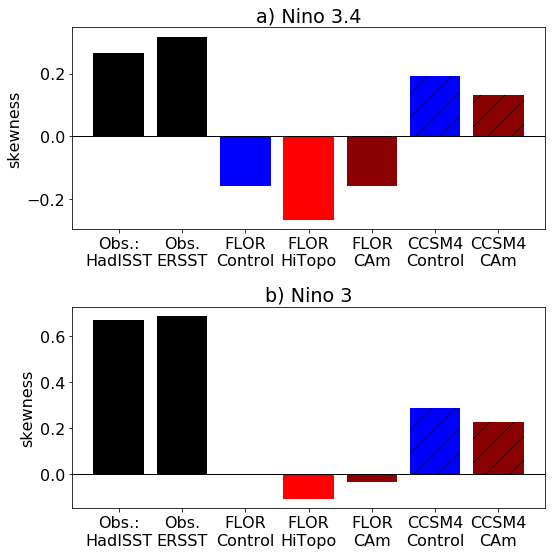

In [21]:
# Skewness

fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})

x = np.arange(0,7)

ax3= plt.subplot(211)
skew34bar1 = [nino34_skew['obs'],nino34_skew['obs_ersst'],nino34_skew['ctrl'],nino34_skew['hitopo'],nino34_skew['cam']]
skew34bar2 = [nino34_skew['ctrl_ccsm'],nino34_skew['cam_ccsm']]
plt.bar(np.arange(0,5),skew34bar1,color=['black', 'black', 'blue', 'red', 'darkred'])
plt.bar(np.arange(5,7),skew34bar2,color=['blue', 'darkred'],hatch='/')
plt.axhline(color='k',linewidth=1)
plt.xticks(x, ('Obs.:\nHadISST','Obs.\nERSST', 'FLOR\nControl', 'FLOR\nHiTopo','FLOR\nCAm','CCSM4\nControl','CCSM4\nCAm'))
plt.ylabel('skewness')
plt.title('a) Nino 3.4')

ax4= plt.subplot(212)
skew3bar1 = [nino3_skew['obs'],nino3_skew['obs_ersst'],nino3_skew['ctrl'],nino3_skew['hitopo'],nino3_skew['cam']]
skew3bar2 = [nino3_skew['ctrl_ccsm'],nino3_skew['cam_ccsm']]
plt.bar(np.arange(0,5),skew3bar1,color=['black', 'black', 'blue', 'red', 'darkred'])
plt.bar(np.arange(5,7),skew3bar2,color=['blue', 'darkred'],hatch='/')
plt.axhline(color='k',linewidth=1)
plt.xticks(x, ('Obs.:\nHadISST','Obs.\nERSST', 'FLOR\nControl', 'FLOR\nHiTopo','FLOR\nCAm','CCSM4\nControl','CCSM4\nCAm'))
plt.ylabel('skewness')
plt.title('b) Nino 3')

plt.tight_layout()

plt.savefig('enso_skew.pdf')